In [ ]:
# Transformers installation
! pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 127.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.4 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset
from datasets import Dataset, Features, ClassLabel, Sequence, Value

def process_data(file):
      f = open(file)
      data = []
      sentences = []
      labels = []
      sentence = []
      label= []
      for line in f:
                  l=line.split('\t')
                  if len(l)==0 or l[0]=="\n" or l[0]=="  \n":
                      if len(sentence) > 0:
                          #data.append((sentence,label))
                          sentences.append(sentence)
                          labels.append(label)
                          sentence = []
                          label = []
                      continue

                  sentence.append(l[0])
                  if l[1].strip() == 'c':
                    label.append(1)
                  else:
                    label.append(0)


      if len(sentence) >0:
                  print("printing data value:", sentence, label)
                  #data.append((sentence,label))
                  sentences.append(sentence)
                  labels.append(label)
                  sentence = []
                  label = []
      
      return {'tokens': sentences, 'ner_tags': labels}


training_data_dict = process_data("train.tsv")

testing_data_dict = process_data("dev.tsv")
testing_data_dict_1 = process_data("test.tsv")

features = Features({'tokens': Sequence(feature=Value(dtype='string', id=None)), 'ner_tags': Sequence(feature=ClassLabel(names=['i', 'c'], id=None), length=-1, id=None)})

my_dataset = Dataset.from_dict({
    'tokens': training_data_dict['tokens'],
    'ner_tags': training_data_dict['ner_tags']
}, features=features)

test_dataset = Dataset.from_dict({
    'tokens': testing_data_dict['tokens'],
    'ner_tags': testing_data_dict['ner_tags']
}, features=features)

test_dataset_1 = Dataset.from_dict({
    'tokens': testing_data_dict_1['tokens'],
    'ner_tags': testing_data_dict_1['ner_tags']
}, features=features)
# realec_dataset = Dataset.from_dict({
#     'tokens': realec_test_dict['tokens'],
#     'ner_tags': realec_test_dict['ner_tags']
# }, features=features)
print("first training example:", my_dataset["tokens"][0])

first training example: ['Dear', 'Sir', 'or', 'Madam', ',']


In [ ]:
label_list = my_dataset.features[f"ner_tags"].feature.names
label_list

['i', 'c']

In [ ]:
from transformers import GPT2Tokenizer
from transformers import GPT2Config, GPT2Model, RobertaConfig
from transformers import AutoTokenizer, OpenAIGPTModel, RobertaModel
# Initializing a GPT2 configuration
configuration = GPT2Config()

# Initializing a RoBERTa configuration
configuration = RobertaConfig()

# Initializing a model (with random weights) from the configuration
model = RobertaModel(configuration)

# Initializing a model (with random weights) from the configuration
# model = GPT2Model(configuration)

# Accessing the model configuration
configuration = model.config
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/roberta-large-ner-english", add_prefix_space=True)

tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# example = wnut["train"][0]
example = my_dataset["tokens"][0]
print("example:", example)
tokenized_input = tokenizer(example,is_split_into_words=True)
print(len(tokenized_input["input_ids"]))
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

example: ['Dear', 'Sir', 'or', 'Madam', ',']
8


['<s>', 'ĠDear', 'ĠSir', 'Ġor', 'ĠMad', 'am', 'Ġ,', '</s>']

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_train_data = my_dataset.map(tokenize_and_align_labels, batched=True)

tokenized_test_data = test_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_data_1 = test_dataset_1.map(tokenize_and_align_labels, batched=True)
# tokenized_realec_data = realec_dataset.map(tokenize_and_align_labels, batched=True)
print(tokenized_test_data_1['labels'][0])

Map:   0%|          | 0/28731 [00:00<?, ? examples/s]

Map:   0%|          | 0/2222 [00:00<?, ? examples/s]

Map:   0%|          | 0/2720 [00:00<?, ? examples/s]

[-100, 1, 1, 1, -100]


In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
print(tokenizer)

RobertaTokenizerFast(name_or_path='Jean-Baptiste/roberta-large-ner-english', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '</s>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)


## Evaluate

In [ ]:
!pip install evaluate
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import evaluate

seqeval = evaluate.load("seqeval")

In [ ]:
import numpy as np

labels = [label_list[i] for i in my_dataset[f"ner_tags"][0]]
print(labels)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

def compute_metrics(p):
    predictions, labels = p
    
    print("labels.shape", labels.shape)
    print("labels", labels)
    predictions = np.argmax(predictions, axis=2)
    print("predictions.shape", predictions.shape)

    predictions_flat = predictions.flatten()
    labels_flat = labels.flatten()
    new_labels = []
    new_predictions = []
    for i in range(len(labels_flat)):
      if(labels_flat[i]!=-100):
        new_labels.append(labels_flat[i])
        new_predictions.append(predictions_flat[i])


    results = accuracy_score(new_labels, new_predictions)
    # print("accuracy: ", results)
    # print("precision: ",precision_score(new_labels, new_predictions,average='macro'))
    # print("recall: ",recall_score(new_labels, new_predictions,average='macro'))
    # print( "F0.5 score:", fbeta_score(new_labels, new_predictions,average='macro', beta=0.5))

    
    return {
        "precision": precision_score(new_labels, new_predictions,average='macro'),
        "recall": recall_score(new_labels, new_predictions,average='macro'),
        "f1": fbeta_score(new_labels, new_predictions,average='macro', beta=1),
        "accuracy": results,
    }

['c', 'c', 'c', 'c', 'c']


## Train

Before you start training your model, create a map of the expected ids to their labels with `id2label` and `label2id`:

In [ ]:
id2label = {
    0: "i",
    1: "c"
}
label2id = {
    "i": 0,
    "c": 1
}

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import GPT2ForTokenClassification, GPTBigCodeModel, GPTNeoForCausalLM, OpenAIGPTModel, RobertaForTokenClassification
model = RobertaForTokenClassification.from_pretrained("Jean-Baptiste/roberta-large-ner-english", num_labels=2, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at Jean-Baptiste/roberta-large-ner-english and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install --upgrade accelerate
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
training_args = TrainingArguments(
    output_dir="roberta-token-class",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

print(my_dataset)


print(test_dataset)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 28731
})
Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 2222
})


Cloning https://huggingface.co/Abhinav2499/gpt2-token-class into local empty directory.


Download file pytorch_model.bin:   0%|          | 17.4k/487M [00:00<?, ?B/s]

Download file runs/May14_02-47-03_0d0beaa2a565/events.out.tfevents.1684032435.0d0beaa2a565.1933.0: 100%|######…

Download file runs/May15_15-24-47_0b053f5776ff/events.out.tfevents.1684164409.0b053f5776ff.2537.0: 100%|######…

Download file runs/May14_15-27-47_9fef936b8400/events.out.tfevents.1684078070.9fef936b8400.1832.6: 100%|######…

Download file runs/May14_14-22-35_9fef936b8400/1684074283.5643399/events.out.tfevents.1684074283.9fef936b8400.…

Download file runs/May14_14-44-57_9fef936b8400/1684075499.6337662/events.out.tfevents.1684075499.9fef936b8400.…

Download file runs/May14_14-22-35_9fef936b8400/events.out.tfevents.1684074283.9fef936b8400.1832.0: 100%|######…

Download file runs/May14_14-46-48_9fef936b8400/1684075611.4386792/events.out.tfevents.1684075611.9fef936b8400.…

Clean file runs/May14_02-47-03_0d0beaa2a565/events.out.tfevents.1684032435.0d0beaa2a565.1933.0:  15%|#5       …

Clean file runs/May15_15-24-47_0b053f5776ff/events.out.tfevents.1684164409.0b053f5776ff.2537.0:   9%|8        …

Clean file runs/May14_15-27-47_9fef936b8400/events.out.tfevents.1684078070.9fef936b8400.1832.6:  13%|#3       …

Clean file runs/May14_14-22-35_9fef936b8400/1684074283.5643399/events.out.tfevents.1684074283.9fef936b8400.183…

Clean file runs/May14_14-44-57_9fef936b8400/1684075499.6337662/events.out.tfevents.1684075499.9fef936b8400.183…

Clean file runs/May14_14-22-35_9fef936b8400/events.out.tfevents.1684074283.9fef936b8400.1832.0:  15%|#5       …

Clean file runs/May14_14-46-48_9fef936b8400/1684075611.4386792/events.out.tfevents.1684075611.9fef936b8400.183…

Download file runs/May15_15-24-47_0b053f5776ff/1684164409.0966165/events.out.tfevents.1684164409.0b053f5776ff.…

Download file runs/May14_15-27-47_9fef936b8400/1684078070.0500562/events.out.tfevents.1684078070.9fef936b8400.…

Download file runs/May14_02-47-03_0d0beaa2a565/1684032435.3075688/events.out.tfevents.1684032435.0d0beaa2a565.…

Clean file runs/May15_15-24-47_0b053f5776ff/1684164409.0966165/events.out.tfevents.1684164409.0b053f5776ff.253…

Clean file runs/May14_02-47-03_0d0beaa2a565/1684032435.3075688/events.out.tfevents.1684032435.0d0beaa2a565.193…

Clean file runs/May14_15-27-47_9fef936b8400/1684078070.0500562/events.out.tfevents.1684078070.9fef936b8400.183…

Download file runs/May14_14-44-57_9fef936b8400/events.out.tfevents.1684075499.9fef936b8400.1832.2: 100%|######…

Download file training_args.bin: 100%|##########| 3.81k/3.81k [00:00<?, ?B/s]

Clean file training_args.bin:  26%|##6       | 1.00k/3.81k [00:00<?, ?B/s]

Download file runs/May14_14-46-48_9fef936b8400/events.out.tfevents.1684075611.9fef936b8400.1832.4: 100%|######…

Clean file runs/May14_14-44-57_9fef936b8400/events.out.tfevents.1684075499.9fef936b8400.1832.2:  22%|##2      …

Clean file runs/May14_14-46-48_9fef936b8400/events.out.tfevents.1684075611.9fef936b8400.1832.4:  18%|#7       …

Clean file pytorch_model.bin:   0%|          | 1.00k/487M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.245100,0.265807,0.878073,0.696156,0.747993,0.909882
2,0.193800,0.247288,0.868270,0.731185,0.777841,0.915344
3,0.145200,0.261442,0.852480,0.758770,0.795283,0.917223
4,0.106800,0.303254,0.849089,0.758394,0.793963,0.916414
5,0.079200,0.350685,0.861175,0.758638,0.797797,0.919044
6,0.059700,0.392440,0.856867,0.763216,0.799875,0.918928
7,0.047900,0.423917,0.855943,0.766620,0.802043,0.919304


labels.shape (2222, 219)
labels [[-100    1 -100 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 ...
 [-100    1    1 ... -100 -100 -100]
 [-100    1    0 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]]
predictions.shape (2222, 219)
labels.shape (2222, 219)
labels [[-100    1 -100 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 ...
 [-100    1    1 ... -100 -100 -100]
 [-100    1    0 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]]
predictions.shape (2222, 219)
labels.shape (2222, 219)
labels [[-100    1 -100 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 ...
 [-100    1    1 ... -100 -100 -100]
 [-100    1    0 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]]
predictions.shape (2222, 219)
labels.shape (2222, 219)
labels [[-100    1 -100 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -10

TrainOutput(global_step=12572, training_loss=0.12768092570394382, metrics={'train_runtime': 7417.8808, 'train_samples_per_second': 27.112, 'train_steps_per_second': 1.695, 'total_flos': 1.573586072250678e+16, 'train_loss': 0.12768092570394382, 'epoch': 7.0})

In [ ]:
loss_history = trainer.state.log_history

In [ ]:

train_loss_values = []
train_loss_epochs = []
eval_loss_values = []
eval_loss_epochs = []

for log in loss_history:
  if "loss" in log:
    train_loss_values.append(log["loss"])
    train_loss_epochs.append(log["epoch"])
  if "train_loss" in log:
    train_loss_values.append(log["train_loss"])
    train_loss_epochs.append(log["epoch"])
  if "eval_loss" in log:
    eval_loss_values.append(log["eval_loss"])
    eval_loss_epochs.append(log["epoch"])

train_loss_values

[0.2936,
 0.2565,
 0.2451,
 0.2249,
 0.1987,
 0.1942,
 0.1938,
 0.1504,
 0.1465,
 0.1452,
 0.142,
 0.1056,
 0.1076,
 0.1068,
 0.0867,
 0.0804,
 0.0792,
 0.077,
 0.0579,
 0.0597,
 0.0597,
 0.0529,
 0.0457,
 0.0461,
 0.0479,
 0.12768092570394382]

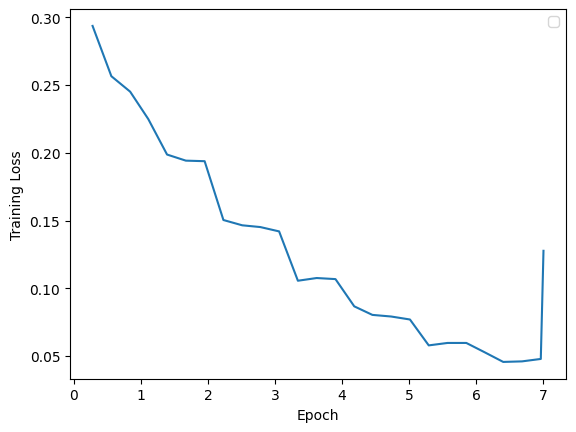

In [ ]:
# Plotting Training Loss Curve

import matplotlib.pyplot as plt
plt.plot(train_loss_epochs, train_loss_values)

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

[0.2658071219921112, 0.24728846549987793, 0.2614423334598541, 0.30325406789779663, 0.35068532824516296, 0.3924396336078644, 0.423917293548584]


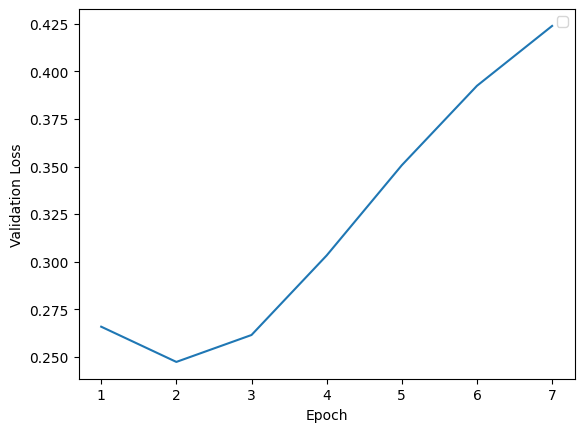

In [ ]:
# Plotting Validation Loss Curve

import matplotlib.pyplot as plt
print(eval_loss_values)
plt.plot(eval_loss_epochs, eval_loss_values)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [ ]:
trainer.push_to_hub()
# trainer.save_model("/")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/May15_16-34-23_b04655a9ffe2/events.out.tfevents.1684168610.b04655a9ffe2.2940.0:   0%|        …

To https://huggingface.co/Abhinav2499/gpt2-token-class
   b434927..54a63cd  main -> main

   b434927..54a63cd  main -> main

To https://huggingface.co/Abhinav2499/gpt2-token-class
   54a63cd..bec27e0  main -> main

   54a63cd..bec27e0  main -> main



'https://huggingface.co/Abhinav2499/gpt2-token-class/commit/54a63cd80c30d74eee65720d6f54bd8878a56c15'

<Tip>

For a more in-depth example of how to finetune a model for token classification, take a look at the corresponding
[PyTorch notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/token_classification.ipynb)
or [TensorFlow notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/token_classification-tf.ipynb).

</Tip>

In [ ]:
text = "I saws an eye."

The simplest way to try out your finetuned model for inference is to use it in a [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline). Instantiate a `pipeline` for NER with your model, and pass your text to it:

In [ ]:
from transformers import pipeline

classifier = pipeline("ner", model="Abhinav2499/gpt2-token-class")
classifier(text)

[{'entity': 'c',
  'score': 0.9930882,
  'index': 0,
  'word': 'ĠI',
  'start': 0,
  'end': 1},
 {'entity': 'c',
  'score': 0.96680385,
  'index': 1,
  'word': 'Ġsaw',
  'start': 1,
  'end': 5},
 {'entity': 'c',
  'score': 0.7405766,
  'index': 2,
  'word': 's',
  'start': 5,
  'end': 6},
 {'entity': 'c',
  'score': 0.888231,
  'index': 3,
  'word': 'Ġan',
  'start': 6,
  'end': 9},
 {'entity': 'c',
  'score': 0.9660869,
  'index': 4,
  'word': 'Ġeye',
  'start': 9,
  'end': 13},
 {'entity': 'c',
  'score': 0.98944074,
  'index': 5,
  'word': '.',
  'start': 13,
  'end': 14}]

You can also manually replicate the results of the `pipeline` if you'd like:

Tokenize the text and return PyTorch tensors:

In [ ]:
from transformers import AutoTokenizer


Pass your inputs to the model and return the `logits`:

In [ ]:
import torch
from torch import cuda
from transformers import AutoModelForTokenClassification
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)
model = AutoModelForTokenClassification.from_pretrained("vp224/gpt2-token-class")
eval_preds, eval_labels = [], []
with torch.no_grad():
  print(len(testing_data_dict_1['tokens']))
  for idx in range(len(testing_data_dict_1['tokens'])):
    print(idx)
    ids = torch.Tensor(tokenized_test_data_1['input_ids'][idx]).to(dtype = torch.long)
    mask = torch.Tensor(tokenized_test_data_1['attention_mask'][idx]).to(dtype = torch.long)
    targets = torch.Tensor(tokenized_test_data_1['labels'][idx]).to(dtype = torch.long)
    



    logits = model(input_ids=ids, attention_mask=mask).logits
    predictions = torch.argmax(logits, dim=1)
    predictions = predictions.tolist()
    # print(predictions)
    eval_labels.extend(targets.tolist())
    eval_preds.extend(predictions)

    if len(targets.tolist()) != len(predictions):
      print("No match")
    # print(loss)
    # logits = model(**inputs).logits
  print(eval_labels)
  print(eval_preds)

cuda


2720
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

In [ ]:
new_labels = []
new_predictions = []
for i in range(len(eval_labels)):
    if(eval_labels[i]!=-100):
      new_labels.append(eval_labels[i])
      new_predictions.append(eval_preds[i])

print(len(new_labels))
print(len(new_predictions))


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

results = accuracy_score(new_labels, new_predictions)
print("accuracy: ", results)
print("precision: ",precision_score(new_labels, new_predictions,average='macro'))
print("recall: ",recall_score(new_labels, new_predictions,average='macro'))
print( "F0.5 score:", fbeta_score(new_labels, new_predictions,average='macro', beta=0.5))

41477
41477
accuracy:  0.6618607903175254
precision:  0.5042693483334095
recall:  0.5065628068358392
F0.5 score: 0.49833092787179456
